In [1]:
# notebook adapted from https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/brain3k/1-Processing-and-Integration.html

In [258]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import sys
import os
from pathlib import Path
import muon as mu
import mudatasets
import seaborn as sns

In [376]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [381]:
from imp import reload
%autoreload 2

20230219-155708.151 37242 INFO root:22 local study files stored in: /Users/ggayq/projects/cellenium/scratch


In [382]:
# import requires setting a PYTHONPATH with the data_import directory
import h5ad_preparation as prep
reload(prep)

20230219-155708.465 37242 INFO root:22 local study files stored in: /Users/ggayq/projects/cellenium/scratch


<module 'h5ad_preparation' from '/Users/ggayq/projects/cellenium/data_import/h5ad_preparation.py'>

In [260]:
mdata = mudatasets.load("brain3k_multiome", data_dir=prep.basedir, full=True)

■ File filtered_feature_bc_matrix.h5 from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_peak_annotation.tsv
■ Checksum is v

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/filtered_feature_bc_matrix.h5


/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:671: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:671: FutureWarning: In a future versio

Added peak annotation from /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz


In [261]:
mdata.var_names_make_unique()

# RNA

In [262]:
rna = mdata['rna']

In [263]:
prep.jupyter_h5ad_overview(rna)

""
AAACAGCCATAGACTT-1
AAACAGCCATTATGCG-1
AAACCAACATAGACCC-1
AAACCGAAGATGCCTG-1
AAACCGAAGTTAGCTA-1
...
TTTGTGGCAAGGAATC-1
TTTGTGGCATGCTTAG-1
TTTGTGTTCGTTACAA-1
TTTGTTGGTGATCAGC-1


,gene_ids,feature_types,genome,interval
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,chr1:29553-30267
FAM138A,ENSG00000237613,Gene Expression,GRCh38,chr1:36080-36081
OR4F5,ENSG00000186092,Gene Expression,GRCh38,chr1:65418-69055
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,chr1:120931-133723
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,chr1:91104-91105
...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,KI270728.1:1270983-1270984
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,KI270731.1:13000-13001
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,KI270734.1:72410-72411
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,KI270734.1:131493-131494


(3233, 36601)

<3233x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 9976712 stored elements in Compressed Sparse Row format>

OverloadedDict, wrapping:
	OrderedDict()
With overloaded keys:
	['neighbors'].

In [264]:
prep.make_sparse(rna)

In [265]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [266]:
# filter
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 8000))
mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 40000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 2)

In [267]:
# normalize
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

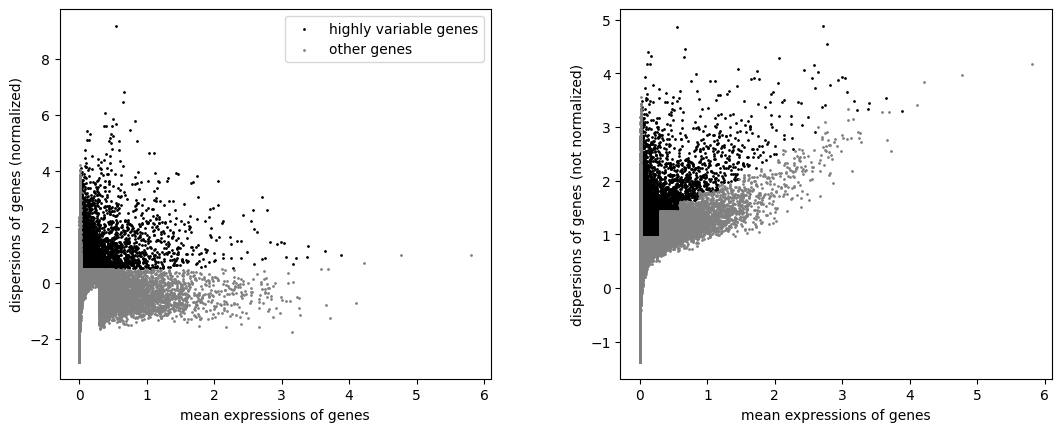

In [268]:
# Prepare umap
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)

In [269]:
# save the lognorm
rna.layers["lognorm"] = rna.X.copy()

In [270]:
sc.pp.scale(rna, max_value=10)

In [271]:
sc.tl.pca(rna, svd_solver='arpack')

In [272]:
# clustering
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna, resolution=.5)

... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


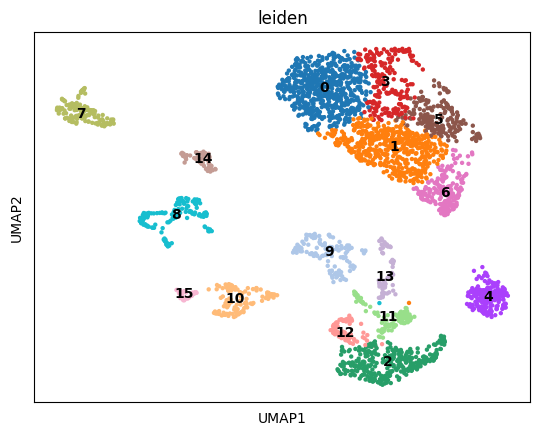

In [273]:
# umap
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna, color="leiden", legend_loc="on data")

In [275]:
new_cluster_names = {
    "0": "oligodendrocyte",
    "1": "oligodendrocyte",
    "3": "oligodendrocyte",
    "5": "oligodendrocyte",
    "6": "oligodendrocyte",
    "4": "OPC",
    "9": "microglia",
    "2": "astrocyte",
    "11": "astrocyte",
    "12": "astrocyte",
    "13": "astrocyte",
    "8": "inhibitory_LHX6",
    "10": "inhibitory_ADARB2",
    "15": "inhibitory_ADARB2",
    "7": "excitatory_LAMP5",
    "14": "excitatory_RORB",
}

In [276]:
rna.obs['celltype'] = [new_cluster_names[cl] for cl in rna.obs.leiden.astype("str").values]
rna.obs.celltype = rna.obs.celltype.astype("category")
rna.obs.celltype = rna.obs.celltype.cat.set_categories([
    'oligodendrocyte', 'OPC', 'microglia', 'astrocyte',
    'excitatory_LAMP5', 'excitatory_RORB',
    'inhibitory_LHX6', 'inhibitory_ADARB2'
])

In [353]:
prep.calculate_differentially_expressed_genes(rna, ['celltype'])

diff.exp. genes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.70s/it]
20230219-153208.918 37242 INFO root:331 calculate_differentially_expressed_genes: found a list of genes for these attributes: ['celltype']


,names,scores,logfoldchanges,pvals,pvals_adj,ref_attr_value,cmp_attr_value,attribute_name
0,CTNNA3,44.237213,5.987654,0.000000e+00,0.000000e+00,oligodendrocyte,_OTHERS_,celltype
1,IL1RAPL1,43.591240,4.119287,0.000000e+00,0.000000e+00,oligodendrocyte,_OTHERS_,celltype
2,ST18,43.456230,6.802461,0.000000e+00,0.000000e+00,oligodendrocyte,_OTHERS_,celltype
3,SLC44A1,43.338531,4.373565,0.000000e+00,0.000000e+00,oligodendrocyte,_OTHERS_,celltype
4,SLC24A2,43.300148,4.668802,0.000000e+00,0.000000e+00,oligodendrocyte,_OTHERS_,celltype
...,...,...,...,...,...,...,...,...
795,PTPRD,10.643174,2.138956,1.876256e-26,7.007435e-24,excitatory_RORB,_OTHERS_,celltype
796,RXFP1,10.622256,7.274140,2.348164e-26,8.681330e-24,excitatory_RORB,_OTHERS_,celltype
797,ME3,10.619894,3.375950,2.408339e-26,8.814760e-24,excitatory_RORB,_OTHERS_,celltype
798,TAFA2,10.611122,4.162472,2.645531e-26,9.587039e-24,excitatory_RORB,_OTHERS_,celltype


In [277]:
rna.X = rna.layers['lognorm']

In [278]:
prep.remove_raw_and_layers(rna)

# ATAC

In [279]:
from muon import atac as ac

In [280]:
atac = mdata.mod['atac']

In [281]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

In [282]:
# filter
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))

In [283]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.93it/s]


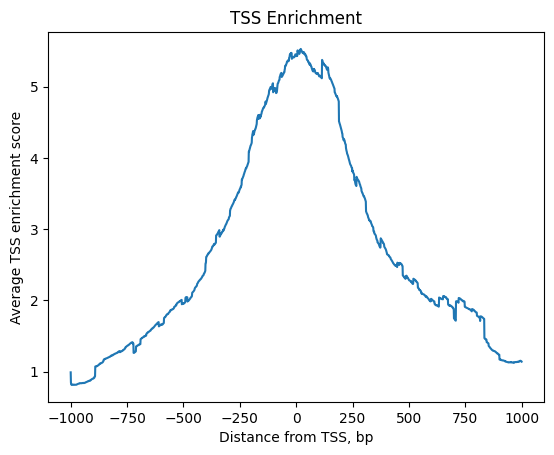

In [284]:
ac.pl.tss_enrichment(tss)

In [285]:
# normalisation
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
atac.layers['lognorm'] = atac.X

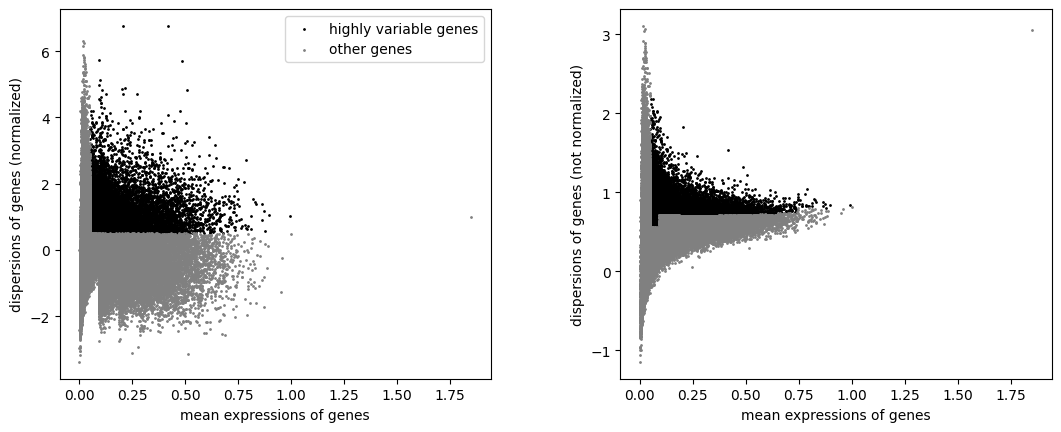

In [286]:
# variable regions
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)

In [287]:
# prepare umap
sc.pp.scale(atac, max_value=10)
sc.tl.pca(atac, svd_solver='arpack')

In [288]:
# clustering
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)
sc.tl.leiden(atac, resolution=.5)

In [289]:
# umap
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)

... storing 'feature_types' as categorical
... storing 'genome' as categorical
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


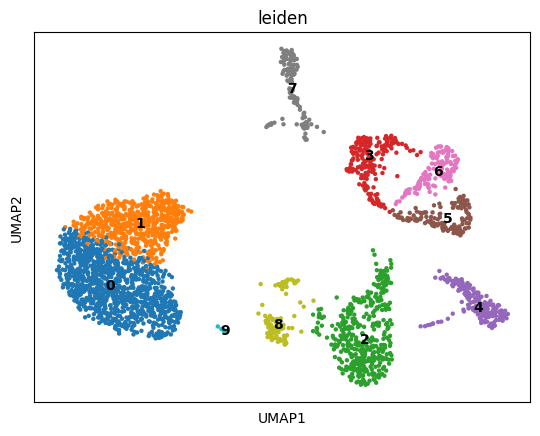

In [290]:
sc.pl.umap(atac, color="leiden", legend_loc="on data")

In [361]:
# get differential peaks
ac.tl.rank_peaks_groups(atac, 'celltype', method='t-test')

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py

In [296]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names

try:
    pd.set_option("max_columns", 50)
except:
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
    pd.set_option("display.max_columns", 50)

pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)


,0_n,0_g,0_p,1_n,1_g,1_p,2_n,2_g,2_p,3_n,3_g,3_p,4_n,4_g,4_p,5_n,5_g,5_p,6_n,6_g,6_p,7_n,7_g,7_p,8_n,8_g,8_p,9_n,9_g,9_p
0,chr19:10517127-10518023,S1PR5,1.891006e-117,chr9:137194149-137195061,"SSNA1, TPRN",1.899970e-08,chr15:88954455-88955355,MFGE8,1.909158e-53,chr3:93470143-93471053,,8.690780e-62,chr20:64205357-64206289,MYT1,2.161480e-24,chr2:172102411-172103256,"DLX2, DLX2-DT",2.293282e-17,chr3:93470143-93471053,,2.567408e-32,chr8:141128016-141128911,"DENND3, AC040970.1",2.511727e-16,chr3:93470143-93471053,,1.412977e-10,chr5:5421992-5422922,"ICE1, AC091978.1",5.036890e-08
1,chr17:4533823-4534672,"MYBBP1A, SPNS2",7.273879e-105,chr1:26555262-26556177,RPS6KA1,2.234563e-08,chr11:116113975-116114894,LINC02703,4.379307e-49,chr19:17830561-17831448,"JAK3, INSL3",1.994329e-26,chr1:235649644-235650468,GNG4,1.018427e-19,chr19:17830561-17831448,"JAK3, INSL3",1.526804e-13,chr7:98869781-98870591,TMEM130,4.952729e-17,chr19:16324216-16325125,KLF2,1.639926e-15,chr14:93926839-93927741,"FAM181A, FAM181A-AS1",5.578371e-10,chr3:150762879-150763765,"SIAH2, SIAH2-AS1",3.660536e-05
2,chr9:137025205-137026128,"ABCA2, C9orf139",1.134110e-97,chr3:134366739-134367654,AMOTL2,3.910449e-08,chr17:7667553-7668441,TP53,4.965136e-47,chr22:20424868-20425672,SCARF2,2.042306e-23,chr7:159144522-159145447,VIPR2,1.325852e-19,chr11:43580653-43581568,"MIR670HG, AC068205.1",1.934198e-13,chr6:34465545-34466455,PACSIN1,5.421669e-16,chr19:16896819-16897691,"F2RL3, CPAMD8",1.884857e-14,chr22:44668148-44669084,PRR5,2.049368e-09,chr9:4740847-4741719,AK3,1.084189e-05
3,chr16:1046313-1047208,AC009041.3,2.984574e-90,chr11:67410019-67410923,"CARNS1, TBC1D10C",5.324076e-08,chr2:63050200-63051132,OTX1,7.300666e-46,chr3:6860613-6861507,GRM7,1.806645e-23,chr10:115092748-115093673,ATRNL1,1.429016e-19,chr1:159141445-159142305,CADM3,5.915898e-13,chr20:38723830-38724734,SLC32A1,5.596753e-16,chr19:6730124-6731045,GPR108,3.679240e-14,chr5:90558277-90559161,ADGRV1,2.086448e-09,chr6:41712509-41713277,"TFEB, AL035588.1",3.375332e-05
4,chr16:19005407-19006339,TMC7,7.007503e-89,chr2:155733016-155733956,,6.761647e-08,chr3:93470143-93471053,,6.415975e-48,chr3:11136760-11137765,HRH1,1.132165e-22,chr22:37412328-37413244,ELFN2,1.669758e-19,chr20:63501902-63502698,AL121829.1,1.027691e-12,chr2:172084895-172085680,DLX1,4.264620e-15,chr5:40679337-40680186,"PTGER4, TTC33",9.874328e-14,chr7:153523847-153524661,LINC01287,3.070767e-09,chr5:68187291-68188210,LINC02219,8.983453e-05
5,chr9:137021806-137022721,"C9orf139, ABCA2",8.155130e-87,chr9:137025205-137026128,"ABCA2, C9orf139",7.688644e-08,chr10:117551948-117552792,EMX2OS,2.072447e-44,chr2:96148230-96149146,AC012307.1,1.931179e-21,chr1:103108243-103109114,COL11A1,3.066909e-19,chr20:38723830-38724734,SLC32A1,1.288271e-12,chr22:43862092-43862988,SULT4A1,8.645210e-15,chr2:8583428-8584334,LINC01814,1.619465e-13,chr12:126742073-126742937,"LINC00943, LINC00944",3.932342e-09,chr17:60599687-60600583,PPM1D,1.355019e-04
6,chr1:25563471-25564360,"LDLRAP1, AL606491.1",1.072256e-84,chr19:8390568-8391057,"RAB11B, RAB11B-AS1",1.126409e-07,chr1:59986377-59987289,CYP2J2,3.596186e-44,chr19:42352133-42353032,MEGF8,9.774738e-21,chr14:28766242-28767112,FOXG1,1.565345e-18,chr10:133336493-133337402,CALY,1.788449e-12,chr2:172102411-172103256,"DLX2, DLX2-DT",1.678811e-14,chr19:48492859-48493838,LMTK3,7.564867e-13,chr1:19643792-19644718,NBL1,3.663762e-09,chr2:241355778-241356651,FARP2,1.397695e-04
7,chr9:128408873-128409744,CERCAM,8.154831e-84,chr7:28408777-28409685,CREB5,2.118926e-07,chr4:7244199-7245095,SORCS2,7.491149e-44,chr7:45407786-45408730,AC073325.1,1.132025e-19,chr3:119329382-119330238,"ARHGAP31-AS1, ARHGAP31",2.371176e-18,chr7:45920598-45921486,IGFBP3,1.964926e-12,chr1:59814315-59815178,HOOK1,2.528833e-14,chr17:82216461-82217320,AC132872.2,1.650544e-12,chr15:88954455-88955355,MFGE8,5.707472e-09,chr15:39920566-39921425,"GPR176, GPR176-DT",2.180990e-04
8,chr5:669160-670066,"TPPP, AC026740.1",9.711095e-82,chr20:48656406-48657246,"AL035106.1, PREX1",2.722846e-07,chr3:4754

In [297]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["9"]))

In [298]:
new_cluster_names = {
    "0": "oligodendrocyte",
    "1": "oligodendrocyte",
    "4": "OPC",
    "7": "microglia",
    "2": "astrocyte",
    "8": "astrocyte",
    "3": "excitatory",
    "5": "inhibitory1",
    "6": "inhibitory2",
}

In [299]:
# assign new names
atac.obs['celltype'] = [new_cluster_names[cl] for cl in atac.obs.leiden.astype("str").values]
atac.obs.celltype = atac.obs.celltype.astype("category")

In [300]:
# order
atac.obs.celltype = atac.obs.celltype.cat.set_categories([
    'oligodendrocyte', 'OPC', 'microglia', 'astrocyte',
    'excitatory', 'inhibitory1', 'inhibitory2'
])

In [301]:
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(to_hex, colors))

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


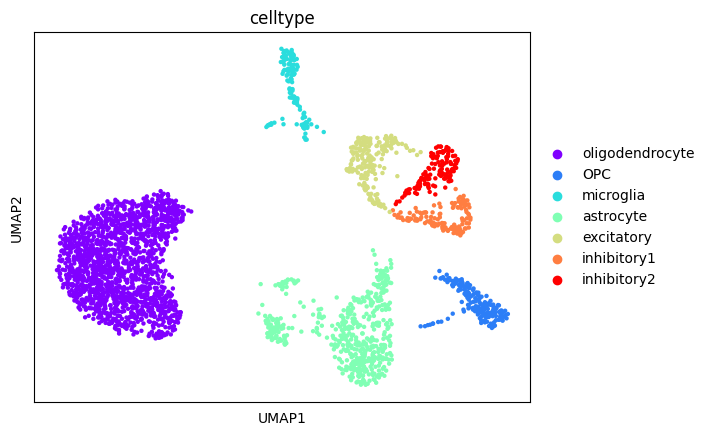

In [302]:
sc.pl.umap(atac, color="celltype")

In [303]:
prep.remove_raw_and_layers(atac)

In [304]:
mdata.update()

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [305]:
mu.pp.intersect_obs(mdata)

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [306]:
from sklearn.metrics import adjusted_rand_score as ari
ari(mdata.obs['rna:celltype'], mdata.obs['atac:celltype'])

0.9629399739332878

In [307]:
# Calculate total number of cells of respective ATAC celltypes
df_total = (
    mdata.obs.groupby("atac:celltype").
        size().
        reset_index(name="n_total").
        set_index("atac:celltype")
)

# Calculate number of cells for each pair of RNA-ATAC celltype annotation
df = (
    mdata.obs.groupby(["atac:celltype", "rna:celltype"]).
        size().
        reset_index(name="n").
        set_index("atac:celltype").
        join(df_total).
        reset_index()
)

# Calculate a fraction of cells of each RNA celltype (n)
# for each ATAC celltype (/ n_total)
df_frac = df.assign(frac = lambda x: x.n / x.n_total)

In [308]:
df_wide = df_frac.set_index("atac:celltype").pivot(columns="rna:celltype", values="frac")

<AxesSubplot: xlabel='rna:celltype', ylabel='atac:celltype'>

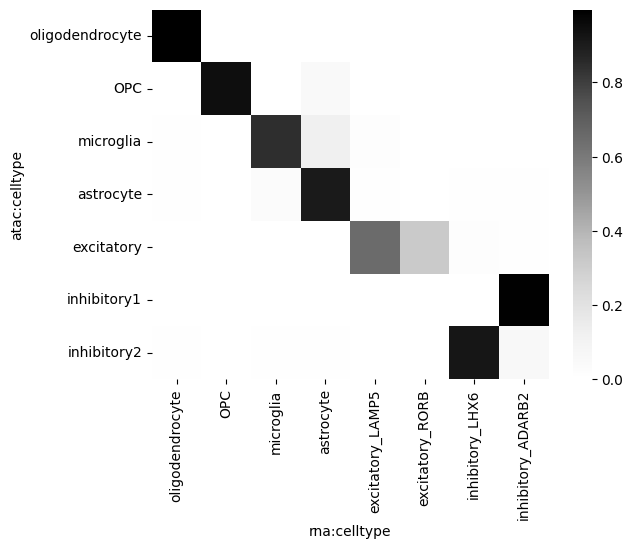

In [309]:
import seaborn as sns
sns.heatmap(df_wide, cmap="Greys")

In [316]:
prep.remove_raw_and_layers(atac)

In [328]:
atac.uns['files'] = dict(atac.uns['files'])
atac.uns['atac'] = dict(atac.uns['atac'])

In [383]:
prep.calculate_differential_peaks(atac, ['celltype'])

differential peaks:   0%|                                                                                                                   | 0/1 [00:00<?, ?it/s]/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  se

,names,scores,logfoldchanges,pvals,pvals_adj,ref_attr_value,cmp_attr_value,attribute_name
0,chr19:10517127-10518023,23.160299,NaN,1.144810e-118,1.534389e-113,oligodendrocyte,_OTHERS_,celltype
1,chr9:137025205-137026128,22.544897,NaN,1.506947e-112,5.049403e-108,oligodendrocyte,_OTHERS_,celltype
2,chr17:4533823-4534672,21.034952,NaN,3.140903e-98,7.016255e-94,oligodendrocyte,_OTHERS_,celltype
3,chr20:48656406-48657246,19.982616,NaN,7.802403e-89,1.045756e-84,oligodendrocyte,_OTHERS_,celltype
4,chr16:1046313-1047208,19.851467,NaN,1.070295e-87,1.304106e-83,oligodendrocyte,_OTHERS_,celltype
...,...,...,...,...,...,...,...,...
695,chr1:192580321-192581146,5.519844,NaN,3.393017e-08,2.332134e-05,microglia,_OTHERS_,celltype
696,chr19:13842436-13843316,5.518897,NaN,3.411352e-08,2.332773e-05,microglia,_OTHERS_,celltype
697,chr1:32992180-32992982,5.515582,NaN,3.476284e-08,2.365108e-05,microglia,_OTHERS_,celltype
698,chr19:1213565-1214375,5.512267,NaN,3.542414e-08,2.385878e-05,microglia,_OTHERS_,celltype


In [413]:
prep.set_cellenium_metadata(
    mdata,
    title='3k Brain Cells Multiomics',
    description='Frozen human healthy brain tissue provided by 10X Genomics',
    taxonomy_id=9606,
    ncit_tissue_ids=['C12439'],
    mesh_disease_ids=[],
    X_pseudolayer_name='norm_log_expression',
    modalities = ['atac','rna'],
    main_sample_attributes={'atac':['celltype'], 'rna': ['celltype']}
)

20230219-213602.984 37242 INFO root:24 local study files stored in: /Users/ggayq/projects/cellenium/scratch


In [417]:
mdata.uns['cellenium'].get('import_projections').tolist()

AttributeError: 'dict' object has no attribute 'tolist'

In [415]:
mdata.write(prep.basedir / "brain3k_processed.h5mu")

... storing 'feature_types' as categorical
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'interval' as categorical


In [406]:
mdata.uns['cellenium']

{'main_sample_attributes': {'atac': ['celltype'], 'rna': ['celltype']},
 'title': '3k Brain Cells Multiomics',
 'description': 'Frozen human healthy brain tissue provided by 10X Genomics',
 'taxonomy_id': 9606,
 'ncit_tissue_ids': ['C12439'],
 'mesh_disease_ids': [],
 'X_pseudolayer_name': 'norm_log_expression',
 'secondary_sample_attributes': [],
 'import_projections': ['atac_umap', 'rna_umap'],
 'initial_reader_permissions': None,
 'initial_admin_permissions': None}